# Day 02 homework assignment

Try out different normalisation and variance stabilisation procedures on the PBMC data:

- total count normalisation (using 10k, 1M, or median/mean scaling)
- variance stabilisation (using log1p, sqrt)
- calculate neighbors/UMAP (using all genes, no PCA) and visualise total count number.
- subset the data by average gene expression into low (0-2), medium (2-10), and high (>10) regimes, and do it again.

## 0. Preparation

Import packages:

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

Read in the data:

In [2]:
adata = sc.read_h5ad("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/pbmc3k/pbmc3k_raw.h5ad")

In [3]:
annot = pd.read_csv("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/pbmc3k/pbmc3k_annot.csv")
annot.set_index("index", inplace=True)
adata.obs = adata.obs.join(annot)

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

## 1. Different normalisations

start with total count normalisation, scaling to 10k afterwards. Save it as an `.obsm` slot because the neighbor calculations need it to _not_ be a `layer`.

In [5]:
tmp = sc.pp.normalize_total(adata, target_sum=10000, inplace=False)
adata.obsm["norm_10k"] = tmp["X"]
adata.obs["10k_factors"] = tmp["norm_factor"]

In [6]:
tmp = sc.pp.normalize_total(adata, target_sum=1e6, inplace=False)
adata.obsm["norm_1M"] = tmp["X"]
adata.obs["1M_factors"] = tmp["norm_factor"]

In [7]:
tmp = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.obsm["norm_med"] = tmp["X"]
adata.obs["med_factors"] = tmp["norm_factor"]

## 2. Variance stabilisation

Perform sqrt and log1p transforms on all different normalisations. We're still going to use different `.obsm` slots for the reasons mentioned above.

In [8]:
adata.obsm["log_med"] = np.log1p(adata.obsm["norm_med"])
adata.obsm["log_10k"] = np.log1p(adata.obsm["norm_10k"])
adata.obsm["log_1M"] = np.log1p(adata.obsm["norm_1M"])

adata.obsm["sqrt_med"] = np.sqrt(adata.obsm["norm_med"])
adata.obsm["sqrt_10k"] = np.sqrt(adata.obsm["norm_10k"])
adata.obsm["sqrt_1M"] = np.sqrt(adata.obsm["norm_1M"])

## 3.1 Calculate distances and UMAPs

In [9]:
reps = list(adata.obsm.keys())[0:9]
for rep in reps:
    sc.pp.neighbors(adata, use_rep=rep, key_added=rep)
    sc.tl.umap(adata, neighbors_key=rep)
    adata.obsm[rep + "_umap"] = adata.obsm["X_umap"].copy()

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packag

## 3.2 Visualise total counts on UMAPs 

Steps to plot using matplotlib:

- define a 3x3 canvas
- in each part of the canvas: plot one of the combinations
- indicate via title where each thing is

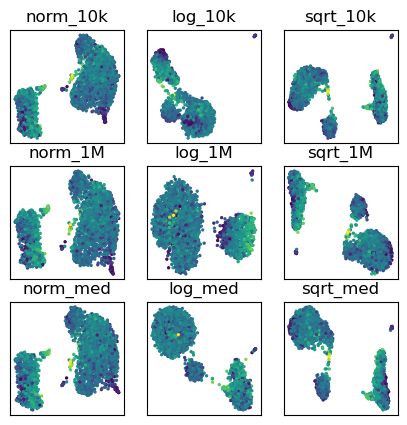

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(5, 5))

reps = ["norm_10k", "log_10k", "sqrt_10k",
        "norm_1M", "log_1M", "sqrt_1M",
        "norm_med", "log_med", "sqrt_med"]

for a, rep in zip(ax.flatten(), reps):
    x = adata.obsm[rep + "_umap"][:, 0]
    y = adata.obsm[rep + "_umap"][:, 1]
    
    a.scatter(x, y, c=adata.obs["log1p_total_counts"], s=2)
    a.set_title(rep)
    a.xaxis.set_visible(False)
    a.yaxis.set_visible(False)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


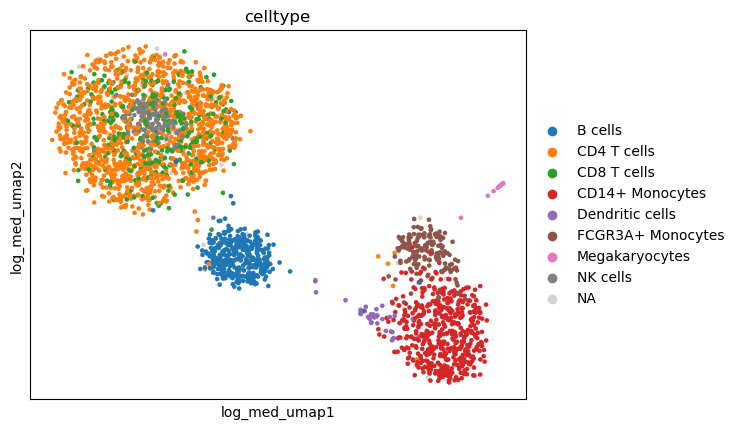

In [15]:
sc.pl.embedding(adata, basis="log_med_umap", color="celltype")

In [17]:
adata.obsm["log_med_pca"] = sc.pp.pca(adata.obsm["log_med"], n_comps=200)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


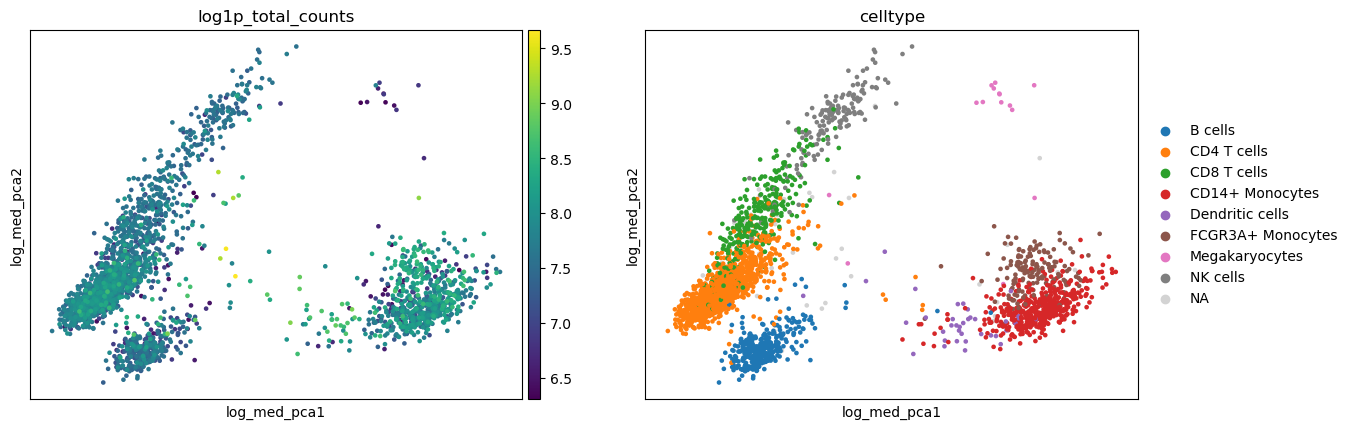

In [20]:
sc.pl.embedding(adata, basis="log_med_pca", color=["log1p_total_counts", "celltype"])

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not index
AAACATACAACCAC-1        CD4 T cells
AAACATTGAGCTAC-1            B cells
AAACATTGATCAGC-1        CD4 T cells
AAACCGTGCTTCCG-1    CD14+ Monocytes
AAACCGTGTATGCG-1           NK cells
                         ...       
TTTCGAACTCTCAT-1    CD14+ Monocytes
TTTCTACTGAGGCA-1            B cells
TTTCTACTTCCTCG-1            B cells
TTTGCATGAGAGGC-1            B cells
TTTGCATGCCTCAC-1        CD4 T cells
Name: celltype, Length: 2700, dtype: object

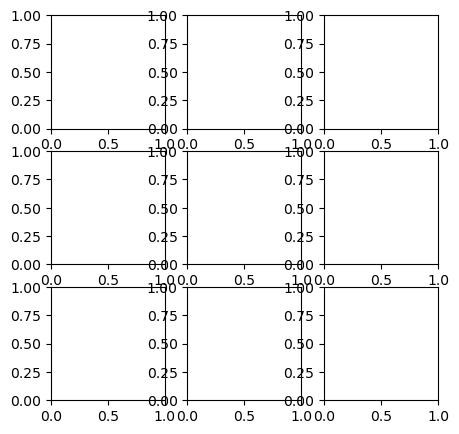

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(5, 5))

reps = ["norm_10k", "log_10k", "sqrt_10k",
        "norm_1M", "log_1M", "sqrt_1M",
        "norm_med", "log_med", "sqrt_med"]

for a, rep in zip(ax.flatten(), reps):
    x = adata.obsm[rep + "_umap"][:, 0]
    y = adata.obsm[rep + "_umap"][:, 1]
    
    a.scatter(x, y, c=adata.obs["celltype"], s=2)
    a.set_title(rep)
    a.xaxis.set_visible(False)
    a.yaxis.set_visible(False)

## 4. subset the data

In [10]:
really_expressed = adata.var["mean_counts"] > 0
low = adata.var["mean_counts"] < 2

In [11]:
low_regime = adata[:, (really_expressed & low)].copy()

In [12]:
low_regime

AnnData object with n_obs × n_vars = 2700 × 16464
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', '10k_factors', '1M_factors', 'med_factors'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'norm_10k', 'umap', 'norm_1M', 'norm_med', 'log_med', 'log_10k', 'log_1M', 'sqrt_med', 'sqrt_10k', 'sqrt_1M'
    obsm: 'norm_10k', 'norm_1M', 'norm_med', 'log_med', 'log_10k', 'log_1M', 'sqrt_med', 'sqrt_10k', 'sqrt_1M', 'X_umap', 'norm_10k_umap', 'norm_1M_umap', 'norm_med_umap', 'log_med_umap', 'log_10k_umap', 'log_1M_umap', 'sqrt_med_umap', 'sqrt_10k_umap', 'sqrt_1M_umap'
    obsp: 'norm_10k_distances', 'norm_10k_connectivities', 'norm_1M_distances', 'norm_1M_connectivities', 'norm_med_distances', 'norm_med_connectivities', 'log_med

In [13]:
tmp = sc.pp.normalize_total(low_regime, target_sum=None, inplace=False)
low_regime.obsm["norm_med"] = tmp["X"]
low_regime.obsm["log_med"] = np.log1p(low_regime.obsm["norm_med"])
low_regime.obsm["sqrt_med"] = np.sqrt(low_regime.obsm["norm_med"])

for rep in ["norm_med", "log_med", "sqrt_med"]:
    sc.pp.neighbors(low_regime, use_rep=rep, key_added=rep)
    sc.tl.umap(low_regime, neighbors_key=rep)
    low_regime.obsm[rep + "_umap"] = low_regime.obsm["X_umap"].copy()

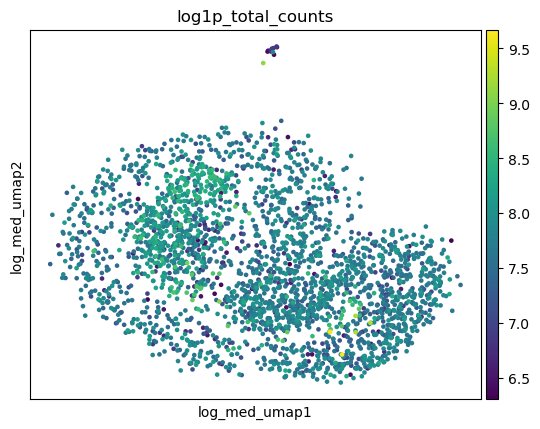

In [14]:
sc.pl.embedding(low_regime, "log_med_umap", color="log1p_total_counts")